<a href="https://colab.research.google.com/github/Om2707/Intraday_Trading_Bot-Using-Python-/blob/main/Intraday_Trading_Bot_Using_Python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install the required libraries
!pip install pandas yfinance ipywidgets

In [ ]:
import yfinance as yf
import pandas as pd

Load the Data

In [ ]:
def get_stock_data(symbol):
    stock = yf.Ticker(symbol)
    hist = stock.history(period="1mo", interval="15m")
    return hist

In [ ]:
symbol = "TATAMOTORS.NS"
stock_data = get_stock_data(symbol)
print(stock_data.tail())

                                 Open        High         Low       Close  \
Datetime                                                                    
2024-06-11 14:00:00+05:30  987.349976  987.650024  984.549988  985.299988   
2024-06-11 14:15:00+05:30  985.400024  990.599976  983.500000  990.150024   
2024-06-11 14:30:00+05:30  990.200012  992.450012  988.049988  991.000000   
2024-06-11 14:45:00+05:30  991.099976  991.849976  989.400024  989.900024   
2024-06-11 15:00:00+05:30  989.799988  990.000000  988.250000  988.750000   

                           Volume  Dividends  Stock Splits  
Datetime                                                    
2024-06-11 14:00:00+05:30  289533        0.0           0.0  
2024-06-11 14:15:00+05:30  684707        0.0           0.0  
2024-06-11 14:30:00+05:30  831985        0.0           0.0  
2024-06-11 14:45:00+05:30  591023        0.0           0.0  
2024-06-11 15:00:00+05:30  128068        0.0           0.0  


Placing Orders

In [ ]:
import ipywidgets as widgets
from IPython.display import display

stock_symbol = widgets.Text(
    value='TATAMOTORS.NS',
    description='Stock Symbol:',
    disabled=False
)

quantity = widgets.IntText(
    value=1,
    description='Quantity:',
    disabled=False
)

order_type = widgets.Dropdown(
    options=['Market', 'Limit'],
    value='Market',
    description='Order Type:',
    disabled=False,
)

product_type = widgets.Dropdown(
    options=['Delivery', 'Intraday'],
    value='Delivery',
    description='Product Type:',
    disabled=False,
)

limit_price = widgets.FloatText(
    value=0.0,
    description='Limit Price:',
    disabled=True,
)

stop_loss = widgets.FloatText(
    value=0.0,
    description='Stop Loss:',
    disabled=False,
)

target_price = widgets.FloatText(
    value=0.0,
    description='Target Price:',
    disabled=False,
)

def update_limit_price(*args):
    limit_price.disabled = order_type.value != 'Limit'

order_type.observe(update_limit_price, 'value')

display(stock_symbol, product_type, quantity, order_type, limit_price, stop_loss, target_price)


Text(value='TATAMOTORS.NS', description='Stock Symbol:')

Dropdown(description='Product Type:', options=('Delivery', 'Intraday'), value='Delivery')

IntText(value=1, description='Quantity:')

Dropdown(description='Order Type:', options=('Market', 'Limit'), value='Market')

FloatText(value=0.0, description='Limit Price:', disabled=True)

FloatText(value=0.0, description='Stop Loss:')

FloatText(value=0.0, description='Target Price:')

Order Execution Details

In [ ]:
class MockTradingBot:
    def __init__(self):
        self.orders = []

    def place_order(self, symbol, quantity, order_type, limit_price, stop_loss, target_price):
        order = {
            'symbol': symbol,
            'quantity': quantity,
            'order_type': order_type,
            'limit_price': limit_price,
            'stop_loss': stop_loss,
            'target_price': target_price,
            'status': 'open'
        }
        self.orders.append(order)
        return order

    def check_orders(self, current_price):
        for order in self.orders:
            if order['status'] == 'open':
                if order['order_type'] == 'Market':
                    order['status'] = 'executed'
                    order['execution_price'] = current_price
                elif order['order_type'] == 'Limit' and current_price <= order['limit_price']:
                    order['status'] = 'executed'
                    order['execution_price'] = current_price

                if 'execution_price' in order:
                    if current_price <= order['stop_loss']:
                        order['status'] = 'stopped out'
                    elif current_price >= order['target_price']:
                        order['status'] = 'target hit'

    def get_orders(self):
        return pd.DataFrame(self.orders)

bot = MockTradingBot()
order = bot.place_order(stock_symbol.value, quantity.value, order_type.value, limit_price.value, stop_loss.value, target_price.value)
print("Order placed:", order)

current_price = stock_data['Close'].iloc[-1]
bot.check_orders(current_price)

orders_df = bot.get_orders()
print(orders_df)



Order placed: {'symbol': 'TATAMOTORS.NS', 'quantity': 1, 'order_type': 'Market', 'limit_price': 0.0, 'stop_loss': 0.0, 'target_price': 0.0, 'status': 'open'}
          symbol  quantity order_type  limit_price  stop_loss  target_price  \
0  TATAMOTORS.NS         1     Market          0.0        0.0           0.0   

       status  execution_price  
0  target hit           988.75  


Price prediction for next 15min for that particular stock

- this predictions are only for intraday trades not for longterm
- longterm suggestions may face operator gaming traps
- for longterm buying do your own fundamental analysis and plans for longterm holding
  for better returns
- Preffered buy at weekly green candles for that particular stock and hold for
  traget as 1:2 or 1:3.  

XGBoost Model


In [ ]:
!pip install ta matplotlib scikit-learn xgboost


In [ ]:
import matplotlib.pyplot as plt
from ta.trend import SMAIndicator, EMAIndicator
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np


In [ ]:
def add_indicators(df):
    df['SMA'] = SMAIndicator(df['Close'], window=15).sma_indicator()
    df['EMA'] = EMAIndicator(df['Close'], window=15).ema_indicator()
    return df

stock_data = add_indicators(stock_data)
print(stock_data.tail())


                                 Open        High         Low       Close  \
Datetime                                                                    
2024-06-11 14:00:00+05:30  987.349976  987.650024  984.549988  985.299988   
2024-06-11 14:15:00+05:30  985.400024  990.599976  983.500000  990.150024   
2024-06-11 14:30:00+05:30  990.200012  992.450012  988.049988  991.000000   
2024-06-11 14:45:00+05:30  991.099976  991.849976  989.400024  989.900024   
2024-06-11 15:00:00+05:30  989.799988  990.000000  988.250000  988.750000   

                           Volume  Dividends  Stock Splits         SMA  \
Datetime                                                                 
2024-06-11 14:00:00+05:30  289533        0.0           0.0  987.123336   
2024-06-11 14:15:00+05:30  684707        0.0           0.0  987.203337   
2024-06-11 14:30:00+05:30  831985        0.0           0.0  987.470003   
2024-06-11 14:45:00+05:30  591023        0.0           0.0  987.586670   
2024-06-11 15:00

In [ ]:
def prepare_data(df, window_size=10):
    df = df.dropna()
    X = []
    y = []

    for i in range(window_size, len(df)):
        X.append(df[['SMA', 'EMA']].iloc[i-window_size:i].values)
        y.append(df['Close'].iloc[i])

    X = np.array(X)
    y = np.array(y)

    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = prepare_data(stock_data)


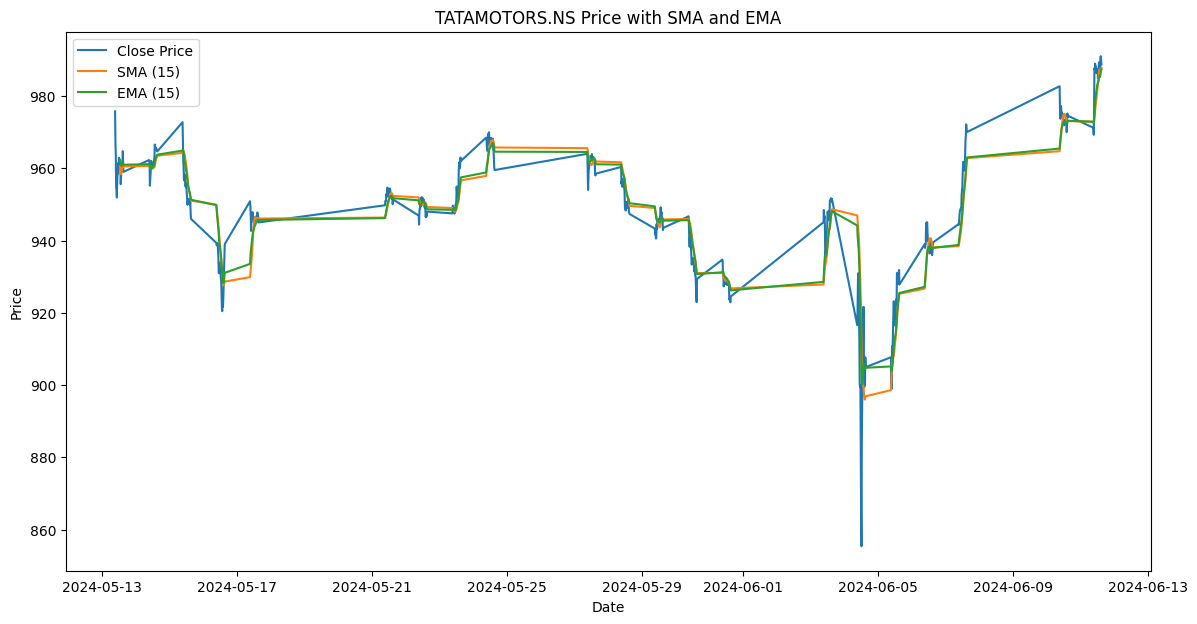

In [ ]:
def plot_stock_data(df, symbol):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.plot(df.index, df['SMA'], label='SMA (15)')
    plt.plot(df.index, df['EMA'], label='EMA (15)')
    plt.title(f'{symbol} Price with SMA and EMA')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_stock_data(stock_data, symbol)


In [ ]:
def train_and_predict(X_train, y_train, X_test):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return model, predictions

model, predictions = train_and_predict(X_train, y_train, X_test)
print(predictions)


[917.15    930.25726 904.8566  948.3498  945.8657  930.9154  905.6309
 950.9696  923.43866 967.995   960.2936  965.77386 943.9815  947.51105
 907.9917  915.09674 988.7694  960.1129  928.67346 935.32324 988.61206
 988.61206 940.0714  931.55597 937.67444 973.6291  990.0785  962.57733
 947.1382  935.3931  976.8696  939.9302  954.0384  962.4409  960.6288
 935.26227 939.32294 924.7576  962.42426 924.9162  920.74    942.8396
 989.1805  970.68134 958.3827  938.38043 959.5797  960.84686 940.22595
 965.2921  928.2459  967.8354  948.36816 943.23047 966.5425  939.28766
 948.16644 963.096   955.38574 929.22894 988.7694  945.501   924.08746
 982.0675  934.1013  954.09204 968.23517 950.5632  948.70245 921.6803
 936.8851  945.43036 944.99994 933.85187 928.44104 930.21246 948.0332
 924.3321  974.68243 972.6834  948.2471  946.4105  975.0883  957.41705
 926.96497 947.3881  966.6659  945.20624 928.88965 944.9067  908.2974
 971.70355 918.0798  924.0678  945.897   952.5407  945.27985 929.72253
 953.8036  9

In [ ]:
def predict_next(model, df, window_size=10):
    latest_data = df[['SMA', 'EMA']].tail(window_size).values
    latest_data = latest_data.reshape(1, -1)
    next_prediction = model.predict(latest_data)
    return next_prediction

next_prediction = predict_next(model, stock_data)
print(f'Next predicted price: {next_prediction[0]}')


Next predicted price: 988.7774047851562


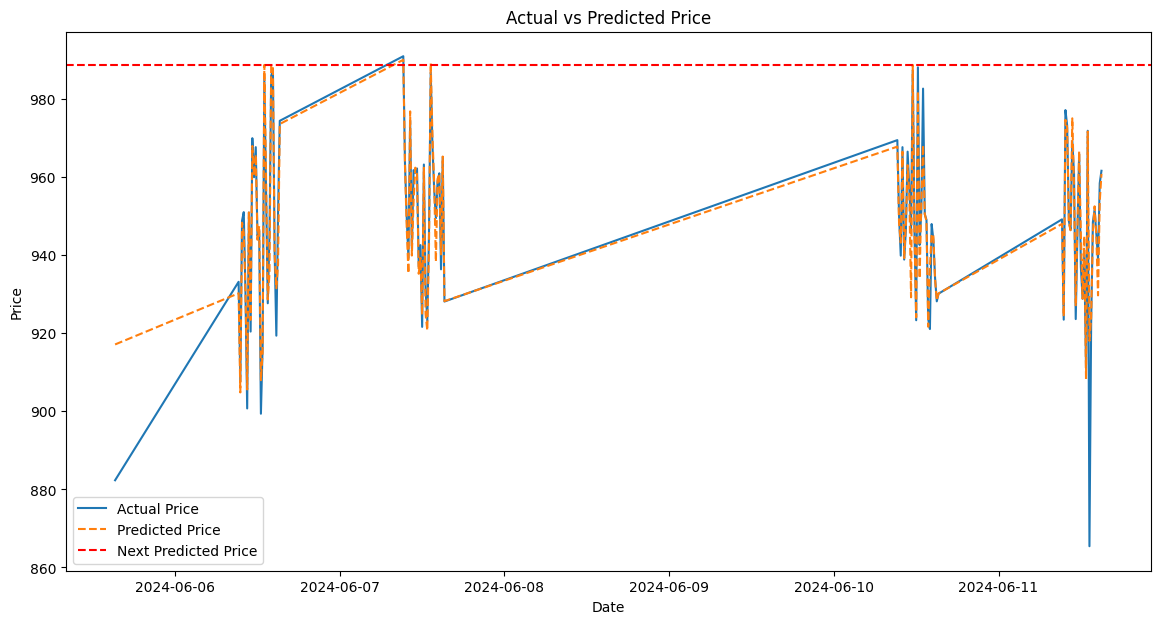

In [ ]:
def plot_predictions(y_test, predictions, next_prediction, stock_data):
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data.index[-len(y_test):], y_test, label='Actual Price')
    plt.plot(stock_data.index[-len(y_test):], predictions, label='Predicted Price', linestyle='dashed')
    plt.axhline(y=next_prediction, color='r', linestyle='--', label='Next Predicted Price')
    plt.title('Actual vs Predicted Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_predictions(y_test, predictions, next_prediction, stock_data)


Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor


In [ ]:
def add_indicators(df):
    df['SMA'] = SMAIndicator(df['Close'], window=15).sma_indicator()
    df['EMA'] = EMAIndicator(df['Close'], window=15).ema_indicator()
    return df

stock_data = add_indicators(stock_data)
print(stock_data.tail())


                                 Open        High         Low       Close  \
Datetime                                                                    
2024-06-11 14:00:00+05:30  987.349976  987.650024  984.549988  985.299988   
2024-06-11 14:15:00+05:30  985.400024  990.599976  983.500000  990.150024   
2024-06-11 14:30:00+05:30  990.200012  992.450012  988.049988  991.000000   
2024-06-11 14:45:00+05:30  991.099976  991.849976  989.400024  989.900024   
2024-06-11 15:00:00+05:30  989.799988  990.000000  988.250000  988.750000   

                           Volume  Dividends  Stock Splits         SMA  \
Datetime                                                                 
2024-06-11 14:00:00+05:30  289533        0.0           0.0  987.123336   
2024-06-11 14:15:00+05:30  684707        0.0           0.0  987.203337   
2024-06-11 14:30:00+05:30  831985        0.0           0.0  987.470003   
2024-06-11 14:45:00+05:30  591023        0.0           0.0  987.586670   
2024-06-11 15:00

In [ ]:
def prepare_data(df, window_size=10):
    df = df.dropna()
    X = []
    y = []

    for i in range(window_size, len(df)):
        X.append(df[['SMA', 'EMA']].iloc[i-window_size:i].values)
        y.append(df['Close'].iloc[i])

    X = np.array(X)
    y = np.array(y)

    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = prepare_data(stock_data)


In [ ]:
def train_and_predict(X_train, y_train, X_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return model, predictions

model, predictions = train_and_predict(X_train, y_train, X_test)
print(predictions)



[919.40550842 927.72800903 902.32400757 948.9920105  949.36400635
 928.59100342 904.74051147 950.4859967  925.48400818 966.74099365
 960.07849915 966.88600525 942.10899414 946.5409906  909.82551208
 918.41001404 989.30951111 959.5979895  928.57750427 939.10899841
 986.67351013 988.46949585 940.9225     931.6585022  930.60400085
 974.13851013 989.67801697 962.04701843 947.00950256 937.84849609
 977.50100403 936.4059967  957.317005   958.01551025 959.76450134
 937.18849915 938.66799805 928.2480072  961.4880072  929.89300781
 916.03200867 945.14249084 986.50900757 968.16399963 958.25299927
 932.45400085 960.90500244 960.42950134 940.82499451 965.28199768
 926.39050964 967.92049622 947.54100342 941.02400024 966.9060022
 939.62148804 947.39549316 963.74149109 958.35100647 933.22650208
 988.81650208 944.52801331 925.21249939 983.60850586 937.4790033
 954.88100464 967.33349243 950.15749817 955.40599915 921.7980072
 943.72000366 946.25999756 944.94650818 934.62551758 928.59250366
 930.39150696

In [ ]:
def predict_next(model, df, window_size=10):
    latest_data = df[['SMA', 'EMA']].tail(window_size).values
    latest_data = latest_data.reshape(1, -1)
    next_prediction = model.predict(latest_data)
    return next_prediction

next_prediction = predict_next(model, stock_data)
print(f'Next predicted price: {next_prediction[0]}')


Next predicted price: 989.4285125732422


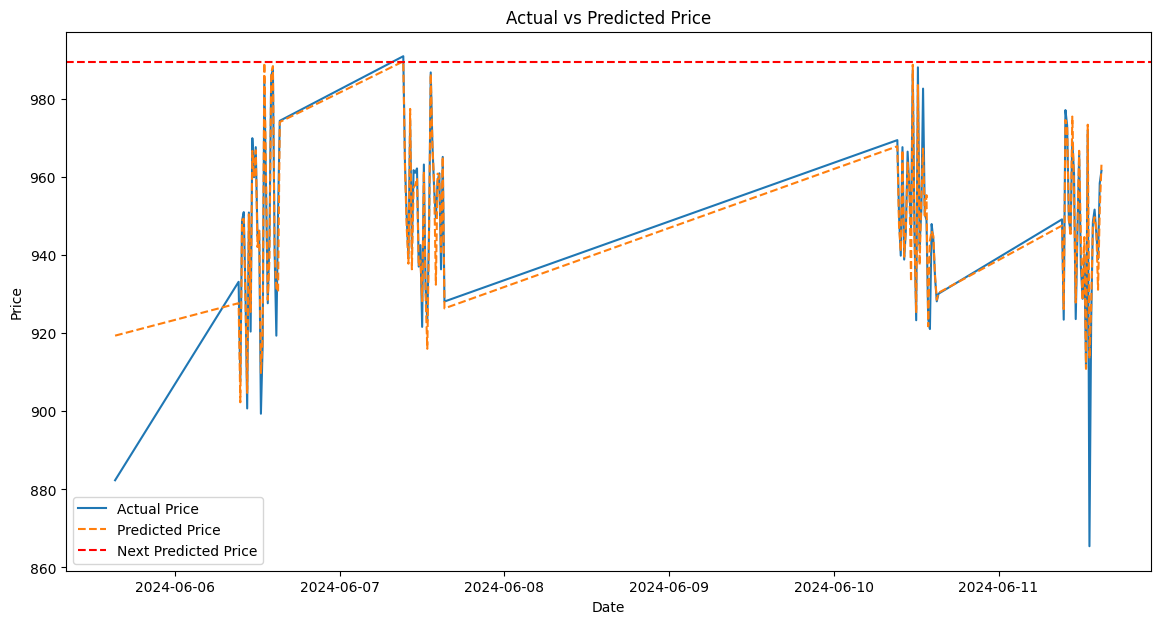

In [ ]:
def plot_predictions(y_test, predictions, next_prediction, stock_data):
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data.index[-len(y_test):], y_test, label='Actual Price')
    plt.plot(stock_data.index[-len(y_test):], predictions, label='Predicted Price', linestyle='dashed')
    plt.axhline(y=next_prediction, color='r', linestyle='--', label='Next Predicted Price')
    plt.title('Actual vs Predicted Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_predictions(y_test, predictions, next_prediction, stock_data)


SVR Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import SMAIndicator, EMAIndicator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR


In [ ]:
def add_indicators(df):
    df['SMA'] = SMAIndicator(df['Close'], window=15).sma_indicator()
    df['EMA'] = EMAIndicator(df['Close'], window=15).ema_indicator()
    return df


In [ ]:
def prepare_data(df, window_size=10):
    df = df.dropna()
    X = []
    y = []

    for i in range(window_size, len(df)):
        X.append(df[['SMA', 'EMA']].iloc[i-window_size:i].values)
        y.append(df['Close'].iloc[i])

    X = np.array(X)
    y = np.array(y)

    return train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
def train_and_predict(X_train, y_train, X_test):
    model = SVR(kernel='rbf')
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return model, predictions


In [ ]:
def predict_next(model, df, window_size=10):
    latest_data = df[['SMA', 'EMA']].tail(window_size).values
    latest_data = latest_data.reshape(1, -1)
    next_prediction = model.predict(latest_data)
    return next_prediction


In [ ]:
def plot_predictions(y_test, predictions, next_prediction, stock_data):
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data.index[-len(y_test):], y_test, label='Actual Price')
    plt.plot(stock_data.index[-len(y_test):], predictions, label='Predicted Price', linestyle='dashed')
    plt.axhline(y=next_prediction, color='r', linestyle='--', label='Next Predicted Price')
    plt.title('Actual vs Predicted Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [ ]:
stock_data = get_stock_data(stock_symbol.value)
stock_data = add_indicators(stock_data)


In [ ]:
X_train, X_test, y_train, y_test = prepare_data(stock_data)


In [ ]:
next_prediction = predict_next(model, stock_data)
print(f'Next predicted price: {next_prediction[0]}')


Next predicted price: 989.4285125732422


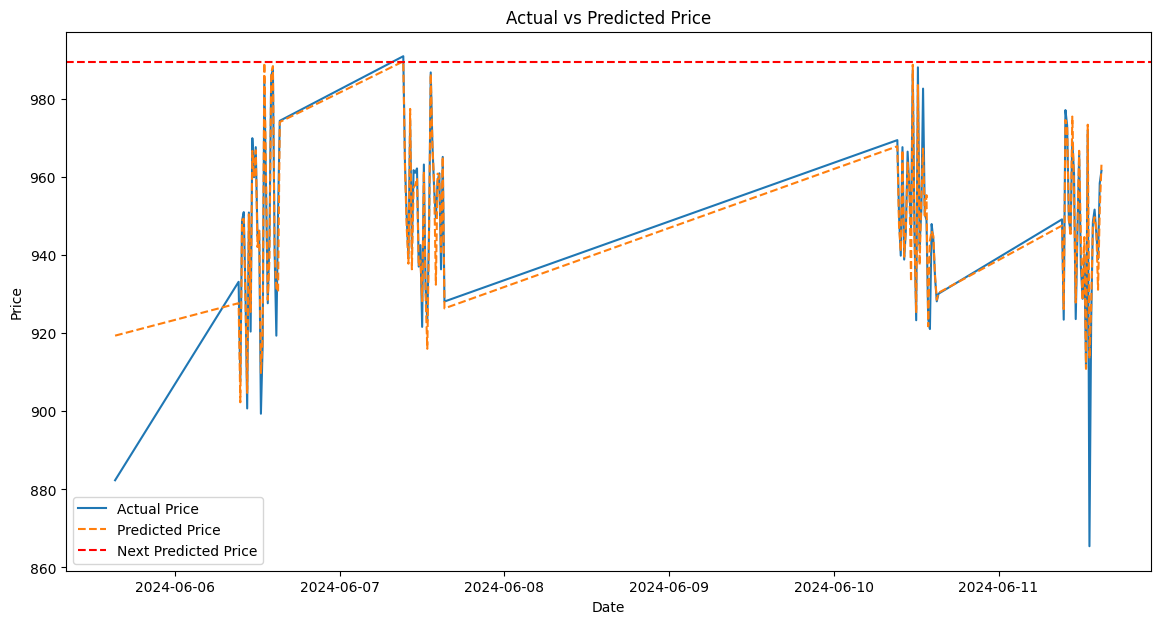

In [ ]:
plot_predictions(y_test, predictions, next_prediction, stock_data)


CNN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import SMAIndicator, EMAIndicator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


In [ ]:
def add_indicators(df):
    df['SMA'] = SMAIndicator(df['Close'], window=15).sma_indicator()
    df['EMA'] = EMAIndicator(df['Close'], window=15).ema_indicator()
    return df


In [ ]:
def prepare_data(df, window_size=10):
    df = df.dropna()
    X = []
    y = []

    for i in range(window_size, len(df)):
        X.append(df[['SMA', 'EMA']].iloc[i-window_size:i].values)
        y.append(df['Close'].iloc[i])

    X = np.array(X)
    y = np.array(y)

    return train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
def train_and_predict(X_train, y_train, X_test):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    predictions = model.predict(X_test)
    return model, predictions


In [ ]:
def predict_next(model, df, window_size=10):
    latest_data = df[['SMA', 'EMA']].tail(window_size).values
    latest_data = latest_data.reshape(1, window_size, 2)
    next_prediction = model.predict(latest_data)
    return next_prediction


In [ ]:
def plot_predictions(y_test, predictions, next_prediction, stock_data):
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data.index[-len(y_test):], y_test, label='Actual Price')
    plt.plot(stock_data.index[-len(y_test):], predictions, label='Predicted Price', linestyle='dashed')
    plt.axhline(y=next_prediction, color='r', linestyle='--', label='Next Predicted Price')
    plt.title('Actual vs Predicted Price with CNN')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [ ]:
stock_data = get_stock_data(stock_symbol.value)
stock_data = add_indicators(stock_data)


In [ ]:
X_train, X_test, y_train, y_test = prepare_data(stock_data)


In [ ]:
model, predictions = train_and_predict(X_train, y_train, X_test)


Epoch 1/20
13/13 [==============================] - 1s 6ms/step - loss: 358135.3125
Epoch 2/20
13/13 [==============================] - 0s 6ms/step - loss: 41958.3516
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 4769.6089
Epoch 4/20
13/13 [==============================] - 0s 5ms/step - loss: 3364.0925
Epoch 5/20
13/13 [==============================] - 0s 6ms/step - loss: 977.3247
Epoch 6/20
13/13 [==============================] - 0s 6ms/step - loss: 242.4946
Epoch 7/20
13/13 [==============================] - 0s 6ms/step - loss: 130.6016
Epoch 8/20
13/13 [==============================] - 0s 6ms/step - loss: 112.4453
Epoch 9/20
13/13 [==============================] - 0s 6ms/step - loss: 106.3317
Epoch 10/20
13/13 [==============================] - 0s 7ms/step - loss: 104.6505
Epoch 11/20
13/13 [==============================] - 0s 8ms/step - loss: 103.8543
Epoch 12/20
13/13 [==============================] - 0s 8ms/step - loss: 103.7145
Epoch 13/20
13/13 

In [ ]:
next_prediction = predict_next(model, stock_data)
print(f'Next predicted price: {next_prediction[0]}')


1/1 [==============================] - 0s 42ms/step
Next predicted price: [986.52625]


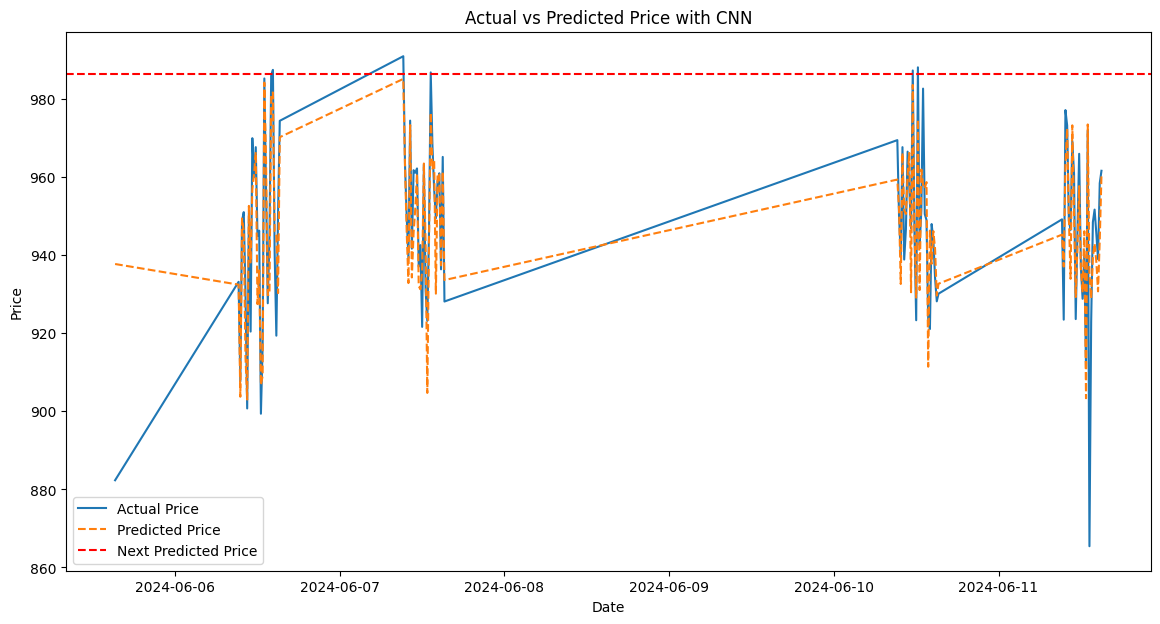

In [ ]:
plot_predictions(y_test, predictions, next_prediction, stock_data)


ARIMA Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import SMAIndicator, EMAIndicator
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def add_indicators(df):
    df['SMA'] = SMAIndicator(df['Close'], window=15).sma_indicator()
    df['EMA'] = EMAIndicator(df['Close'], window=15).ema_indicator()
    return df

In [ ]:
def prepare_data_arima(df):
    df = df.dropna()
    return df['Close']

In [ ]:
def train_and_predict_arima(data, order=(5, 1, 0)):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    start_index = len(data) - int(len(data) * 0.2)
    end_index = len(data) - 1
    predictions = model_fit.predict(start=start_index, end=end_index, typ='levels')
    return model_fit, predictions

In [ ]:
def predict_next_arima(model_fit, data):
    next_prediction = model_fit.forecast(steps=1, exog=data.iloc[[-1]])[0]
    return next_prediction

In [ ]:
def plot_predictions_arima(data, predictions, next_prediction):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[-len(predictions):], data.values[-len(predictions):], label='Actual Price')
    plt.plot(data.index[-len(predictions):], predictions, label='Predicted Price', linestyle='dashed')
    plt.axhline(y=next_prediction, color='r', linestyle='--', label='Next Predicted Price')
    plt.title('Actual vs Predicted Price with ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [ ]:
stock_data = get_stock_data(stock_symbol.value)
stock_data = add_indicators(stock_data)

In [ ]:
data = prepare_data_arima(stock_data)
data.index = pd.date_range(start='2024-01-01', periods=len(data), freq='D')

In [ ]:
model_fit, predictions = train_and_predict_arima(data)

In [ ]:
next_prediction = predict_next_arima(model_fit, data)
print(f'Next predicted price: {next_prediction}')

Next predicted price: 988.6099710646213


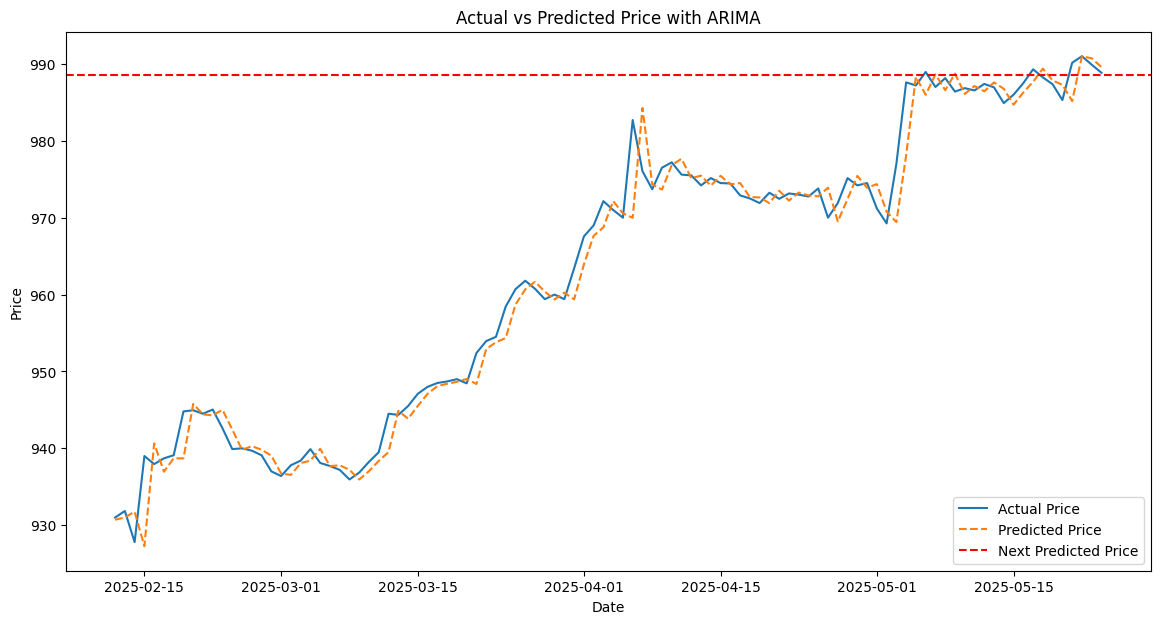

In [ ]:
plot_predictions_arima(data, predictions, next_prediction)

Transformer Series Model

In [ ]:
!pip install pandas yfinance matplotlib scikit-learn torch ta


In [ ]:
import yfinance as yf
import pandas as pd
from ta.trend import SMAIndicator, EMAIndicator

def get_stock_data(symbol):
    stock = yf.Ticker(symbol)
    hist = stock.history(period="1mo", interval="15m")
    return hist

def add_indicators(df):
    df['SMA'] = SMAIndicator(df['Close'], window=15).sma_indicator()
    df['EMA'] = EMAIndicator(df['Close'], window=15).ema_indicator()
    return df

symbol = "TATAMOTORS.NS"
stock_data = get_stock_data(symbol)
stock_data = add_indicators(stock_data)

print(stock_data.tail())


                                 Open        High         Low       Close  \
Datetime                                                                    
2024-06-11 14:00:00+05:30  987.349976  987.650024  984.549988  985.299988   
2024-06-11 14:15:00+05:30  985.400024  990.599976  983.500000  990.150024   
2024-06-11 14:30:00+05:30  990.200012  992.450012  988.049988  991.000000   
2024-06-11 14:45:00+05:30  991.099976  991.849976  989.400024  989.900024   
2024-06-11 15:00:00+05:30  989.799988  990.000000  987.950012  987.950012   

                           Volume  Dividends  Stock Splits         SMA  \
Datetime                                                                 
2024-06-11 14:00:00+05:30  289533        0.0           0.0  987.123336   
2024-06-11 14:15:00+05:30  684707        0.0           0.0  987.203337   
2024-06-11 14:30:00+05:30  831985        0.0           0.0  987.470003   
2024-06-11 14:45:00+05:30  591023        0.0           0.0  987.586670   
2024-06-11 15:00

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size=10):
        self.data = data
        self.window_size = window_size
        self.scaler = MinMaxScaler()
        self.data_scaled = self.scaler.fit_transform(data.values.reshape(-1, 1)).flatten()

    def __len__(self):
        return len(self.data_scaled) - self.window_size

    def __getitem__(self, idx):
        idx_end = idx + self.window_size
        x = self.data_scaled[idx:idx_end]
        y = self.data_scaled[idx_end]
        return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

window_size = 10

dataset = TimeSeriesDataset(stock_data['Close'], window_size=window_size)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, num_layers, num_heads, hidden_size, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_size = hidden_size

        self.embedding = nn.Linear(input_size, hidden_size)

        self.transformer_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )

        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.embedding(x)

        x = self.transformer_layers(x)

        x = self.output_layer(x)
        return x


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.unsqueeze(1))
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item() * inputs.size(0)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader.dataset)}, Val Loss: {val_loss/len(val_loader.dataset)}')

input_size = window_size
num_layers = 2
num_heads = 2
hidden_size = 64
dropout = 0.1
learning_rate = 0.001
num_epochs = 10

model = TimeSeriesTransformer(input_size, num_layers, num_heads, hidden_size, dropout=dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 1.0910773570230117, Val Loss: 0.3658188419434631
Epoch [2/10], Train Loss: 0.13560218112022046, Val Loss: 0.1392881087597134
Epoch [3/10], Train Loss: 0.0672465478933423, Val Loss: 0.01990375298898197
Epoch [4/10], Train Loss: 0.038544828693072, Val Loss: 0.023323640245401744
Epoch [5/10], Train Loss: 0.026139918583334216, Val Loss: 0.033336049144707836
Epoch [6/10], Train Loss: 0.026666822079614422, Val Loss: 0.021225160295234143
Epoch [7/10], Train Loss: 0.02323498979319621, Val Loss: 0.01701112422477273
Epoch [8/10], Train Loss: 0.020738486884900542, Val Loss: 0.021083022205574998
Epoch [9/10], Train Loss: 0.019502875186647957, Val Loss: 0.0124116208838317
Epoch [10/10], Train Loss: 0.016592331223842436, Val Loss: 0.01220305339948645


In [ ]:
def predict_next(model, data, window_size=10):
    model.eval()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
    with torch.no_grad():
        inputs = torch.tensor(data_scaled[-window_size:], dtype=torch.float).unsqueeze(0).unsqueeze(1)
        prediction = model(inputs)
    return scaler.inverse_transform(prediction.squeeze().numpy().reshape(-1, 1))

# Make predictions
next_prediction_ts = predict_next(model, stock_data['Close'])

# Print the next predicted price
print(f'Next predicted price: {next_prediction_ts[0][-1]}')


Next predicted price: 961.5968627929688


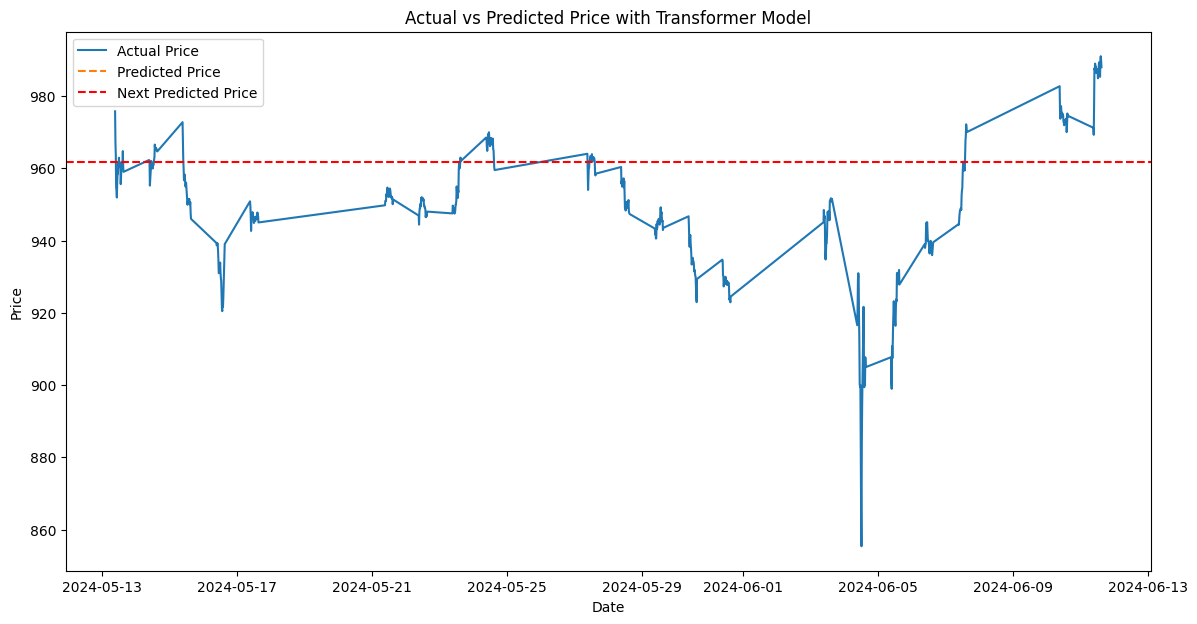

In [ ]:
def plot_predictions_transformer(data, predictions, next_prediction):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data.values, label='Actual Price')

    # Plot predicted prices
    for i in range(len(predictions)):
        plt.plot(data.index[-len(predictions) + i:], predictions[i], linestyle='dashed', label='Predicted Price' if i == 0 else None)

    # Plot next predicted price
    plt.axhline(y=next_prediction, color='r', linestyle='--', label='Next Predicted Price')

    plt.title('Actual vs Predicted Price with Transformer Model')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
plot_predictions_transformer(stock_data['Close'], next_prediction_ts.flatten(), next_prediction_ts[-1][-1])
